In [ ]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import glob
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
%matplotlib inline

# Poisson EM Implementation

In [ ]:
class poisson_clusters():
    def __init__(self, data, num_steps, tol=1e-2):
        '''
        data: numpy array of dimensions (num_samples, num_features)
        '''
        self.data = data
        self.num_data = len(self.data)
        self.num_steps = num_steps
        self.tol = tol

    def prob_poisson(self, data_point, cluster_mean):
        '''Returns the probability of data_point coming from a multivariate poisson distribution with means=cluster_mean'''
        prob = 1
        for k, mu in zip(data_point, cluster_mean):
            prob*=poisson.pmf(k, mu)
        return prob

    def likelihoods(self, cluster_mean_list, mixing_coefficients):
        likelihoods = [[pi*self.prob_poisson(data_point, cluster_mean) for cluster_mean, pi in zip(cluster_mean_list, mixing_coefficients)] for data_point in self.data]
        return likelihoods

    def log_likelihood(self, cluster_mean_list, mixing_coefficients):
        likelihoods = self.likelihoods(cluster_mean_list, mixing_coefficients)
        log_likelihood = np.sum(np.log(np.sum(likelihoods, axis=1)))
        return log_likelihood

    def fit(self, num_clusters):
        self.log_likelihood_list = []

        #Initialize means and mixing coefficients
        rand_idxs = np.random.permutation(len(self.data))
        rand_idxs_partitioned = [rand_idxs[int(i*self.num_data/num_clusters):int((i+1)*self.num_data/num_clusters)] for i in range(num_clusters)]
        self.fit_means = np.array([np.mean(self.data[idxs], axis=0) for idxs in rand_idxs_partitioned])
        self.mixing_coeff = np.ones(num_clusters)/num_clusters

        #Calculate initial value of log-likelihood
        self.log_likelihood_list.append(self.log_likelihood(self.fit_means, self.mixing_coeff))

        #Loop over E steps and M step
        for _ in range(self.num_steps):
            #E-step
            #Evaluate responsibilities
            self.responsibilities = self.likelihoods(self.fit_means, self.mixing_coeff)
            self.responsibilities /= np.sum(self.responsibilities, axis=1)[:, np.newaxis]

            #M-step
            #Re-estimate parameters
            N_k = np.sum(self.responsibilities, axis=0)
            self.fit_means = np.matmul(self.responsibilities.T, self.data)/N_k[:, np.newaxis]
            self.mixing_coeff = N_k/self.num_data

            #Evaluate log-likelihood
            self.log_likelihood_list.append(self.log_likelihood(self.fit_means, self.mixing_coeff))

            if self.log_likelihood_list[-1] - self.log_likelihood_list[-2] < self.tol:
                break

        plt.plot(np.arange(len(self.log_likelihood_list)), self.log_likelihood_list)
        plt.xticks(np.arange(len(self.log_likelihood_list)))
        plt.xlabel('Steps')
        plt.ylabel('Log-likelihood')
        plt.show()

# Synthetic Data: Poisson

Generate data

In [ ]:
#create cluster means here shown for two clusters
poisson_means = 20*np.random.random(size=(2, 100))

#generate datapoints for each cluster and plot
poisson_data = np.vstack([np.random.poisson(mean, size=(500, 100)) for mean in poisson_means])
# plt.imshow(poisson_data, aspect=0.1)
# plt.show()

# #randomize the indices of the dataset and plot
# rand_idx = np.random.permutation(len(poisson_data))
# poisson_data = poisson_data[rand_idx]
# plt.imshow(poisson_data, aspect=0.1)
# plt.show()

Run the model

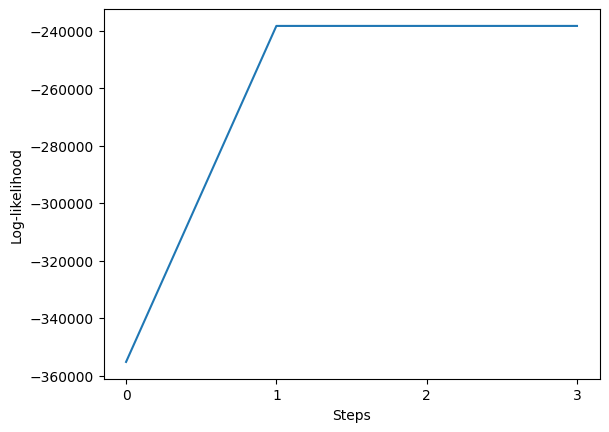

In [ ]:
#Fit poisson_clusters model with two clusters
num_clusters = 2
obj = poisson_clusters(data=poisson_data, num_steps=10)
obj.fit(num_clusters=num_clusters)

Get Predictions

In [ ]:
preds = np.argmax(obj.responsibilities, axis = 1)

Predicted PCA

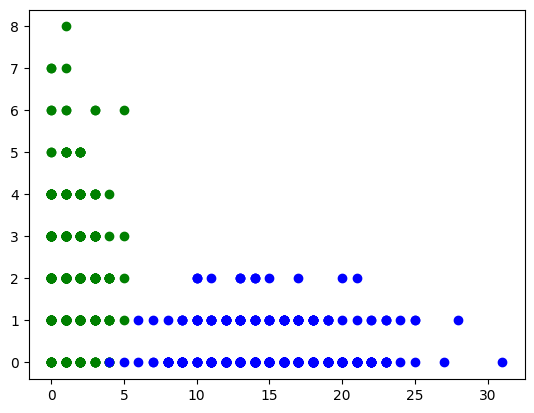

In [ ]:
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(poisson_data)
plt.scatter(poisson_data[preds == 0,1], poisson_data[preds == 0,0], color='green')
plt.scatter(poisson_data[preds == 1,1], poisson_data[preds == 1,0], color='blue')

Adjusted Rand Score

In [ ]:
adjusted_rand_score(np.hstack((np.zeros(500), np.ones(500))), preds)

1.0

Ground Truth PCA

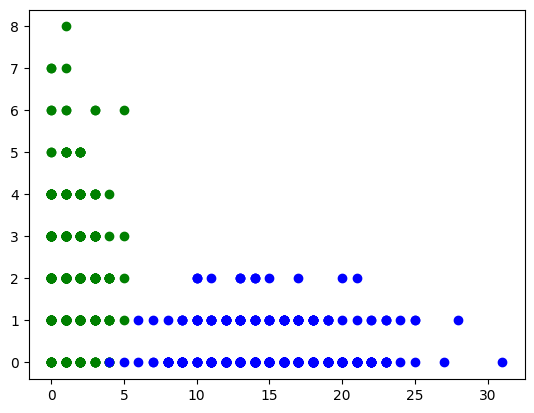

In [ ]:
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(poisson_data)
plt.scatter(poisson_data[:500,1], poisson_data[:500,0], color='green')
plt.scatter(poisson_data[500:1000,1], poisson_data[500:1000,0], color='blue')

# Real World Data: Only Gender

Loading and Pre-processing Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_file_list = glob.glob('/content/drive/MyDrive/ML project/data_*.csv')
data_list = []
for file in data_file_list:
  if file == '/content/drive/MyDrive/ML project/data_cortex_oligo.csv':
    continue
  data = pd.read_csv(file, index_col = 0)
  data = np.array(data)

  # normalize.
  normalized_data = data/np.sum(data, axis = 1)[:,np.newaxis]

  # scale.
  scaler = StandardScaler()
  single_cell_data_scaled = scaler.fit_transform(normalized_data)

  data_list.append(single_cell_data_scaled)


meta_file_list = glob.glob('/content/drive/MyDrive/ML project/meta_*.csv')
labels_gender_list = []
file_names_list = []
labels_cell_names_list = []
for file in meta_file_list:
  # print(file)
  file_name = '.'
  file_names_list.append(file_name.join(file.rstrip('.csv').split('_')[1:]))
  meta_data = pd.read_csv(file, index_col = 0)
  labels_gender = meta_data['mouse.sex'].apply(lambda x: 0 if x == 'M' else 1)
  labels_gender = np.array(labels_gender)
  labels_gender_list.append(labels_gender)


Running the Model

In [ ]:
len(data_list)

11

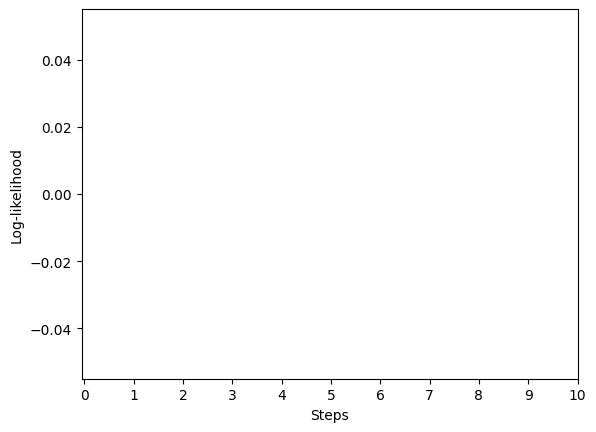

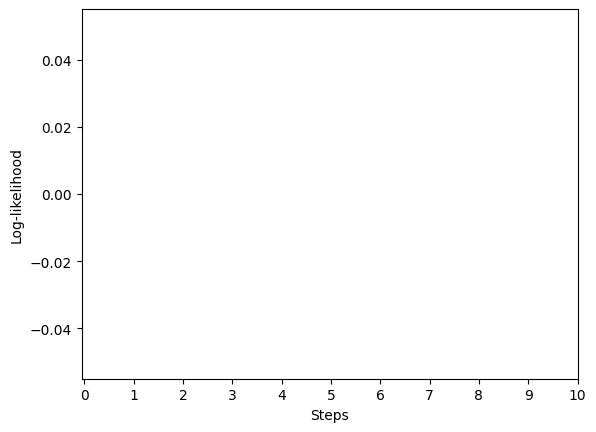

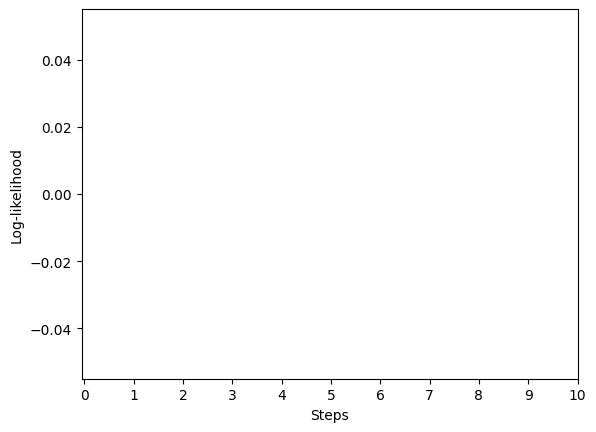

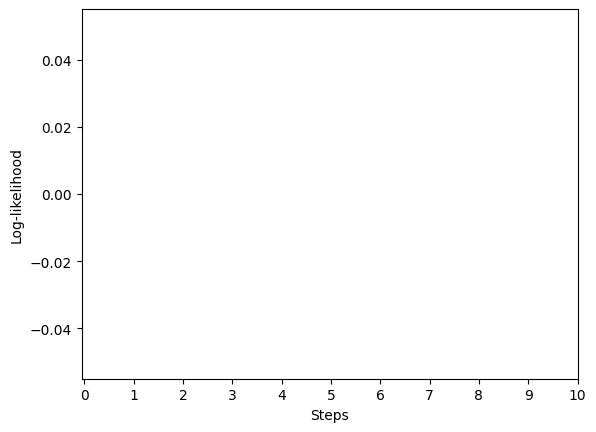

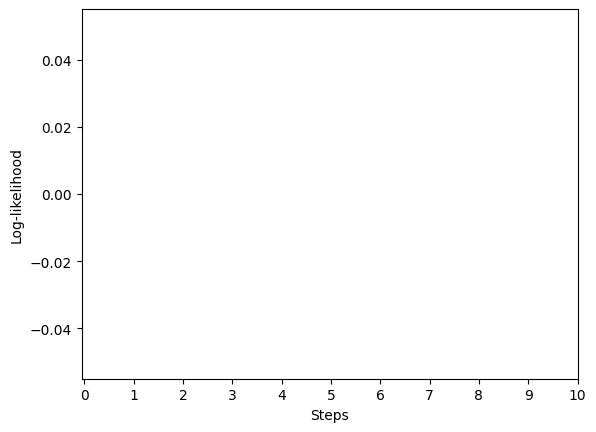

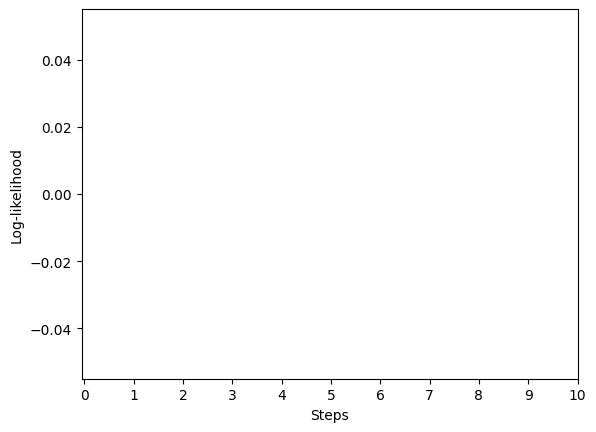

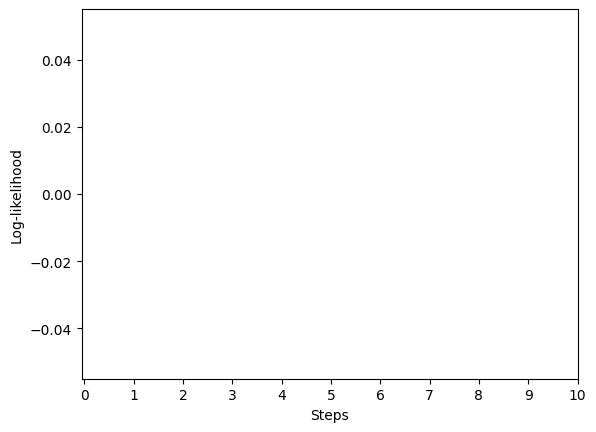

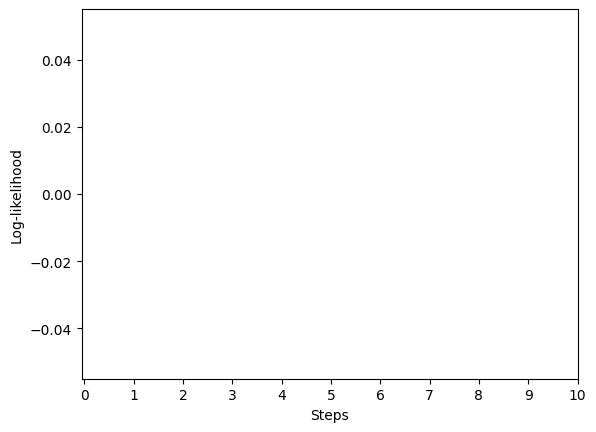

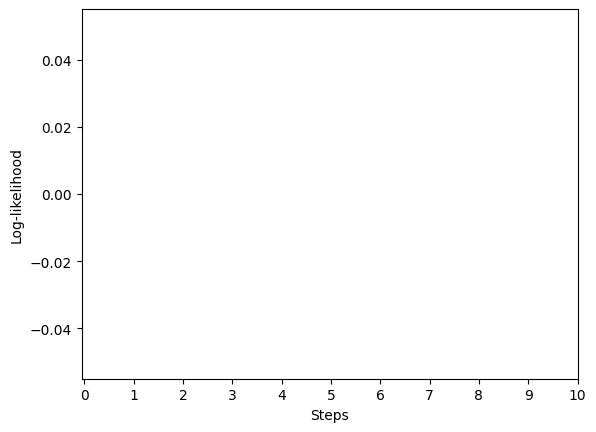

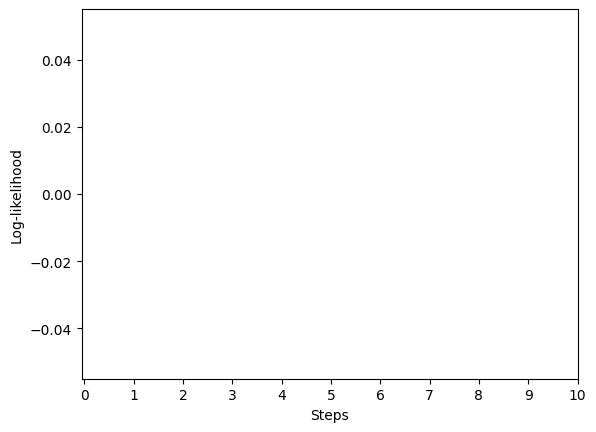

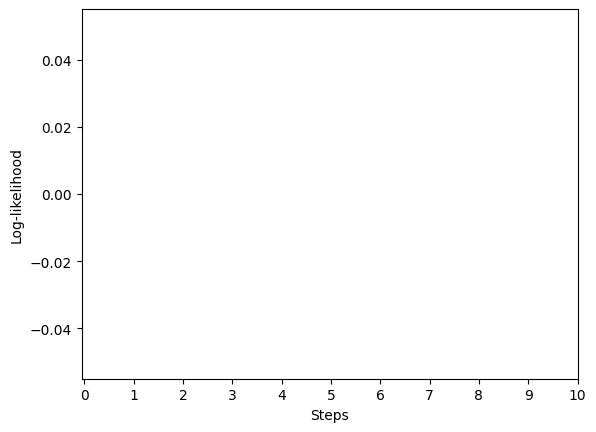

In [ ]:
num_clusters = 2

gender_scores_d = {}
preds_list = []
for data, gender_labels, file_name in zip(data_list, labels_gender_list, file_names_list):

  obj = poisson_clusters(data=data, num_steps=10, tol = 1e-2)
  obj.fit(num_clusters=num_clusters)
  # print()
  # predict.
  preds = np.argmax(obj.responsibilities, axis = 1)
  preds_list.append(preds)

  # evaluate.
  ## 1. gender.
  gender_scores_d[file_name] = adjusted_rand_score(gender_labels, preds)

Adjusted Rand Scores

In [ ]:
gender_scores_d

{'Cerebellum.endothelial cell': 0.0,
 'Cerebellum.neuron': 0.0,
 'Cerebellum.oligodendrocyte': 0.0,
 'Cortex.astrocyte': 0.0,
 'Cortex.endothelial cell': 0.0,
 'Cortex.oligodendrocyte': 0.0,
 'Hippocampus.endothelial cell': 0.0,
 'Hippocampus.oligodendrocyte': 0.0,
 'Striatum.endothelial cell': 0.0,
 'Striatum.neuron': 0.0,
 'Striatum.oligodendrocyte': 0.0}

Predictions PCA

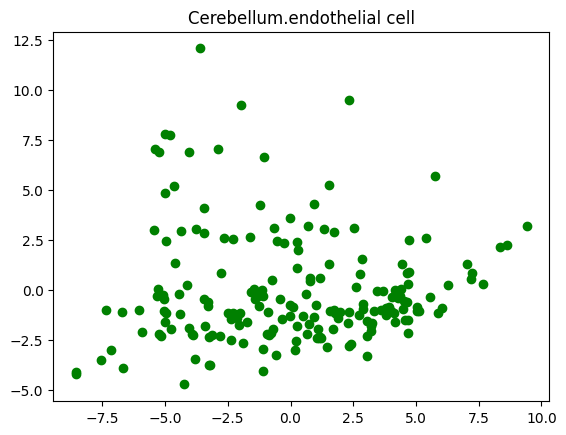

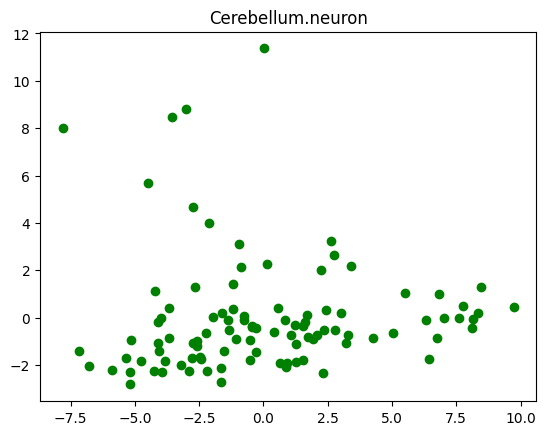

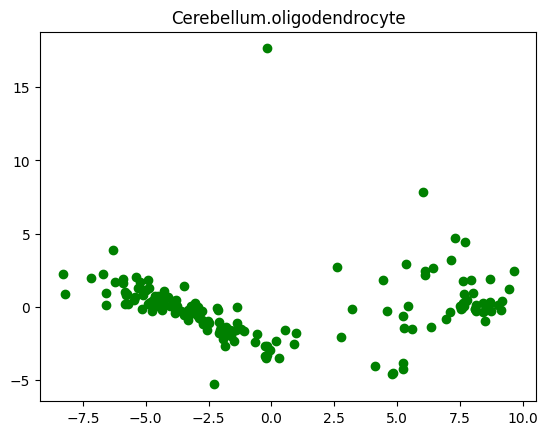

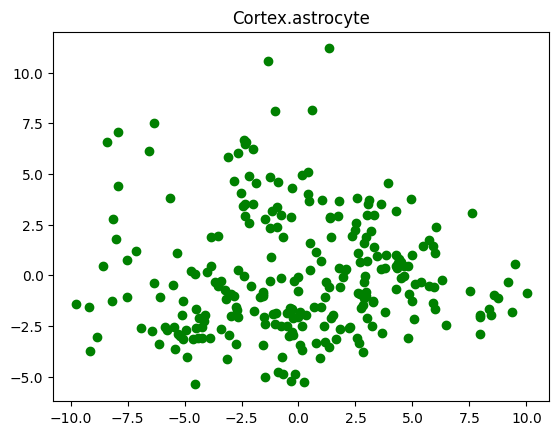

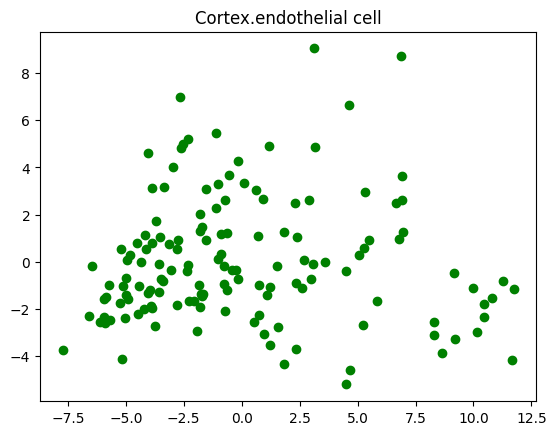

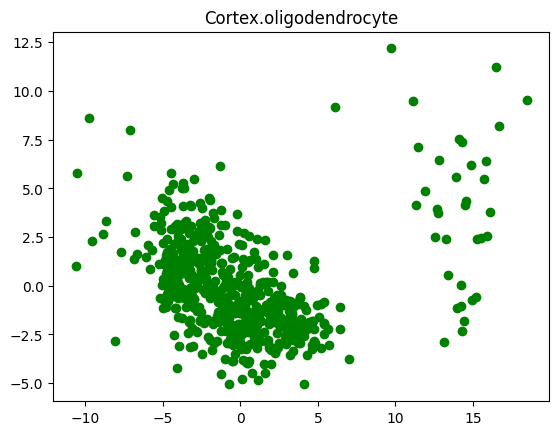

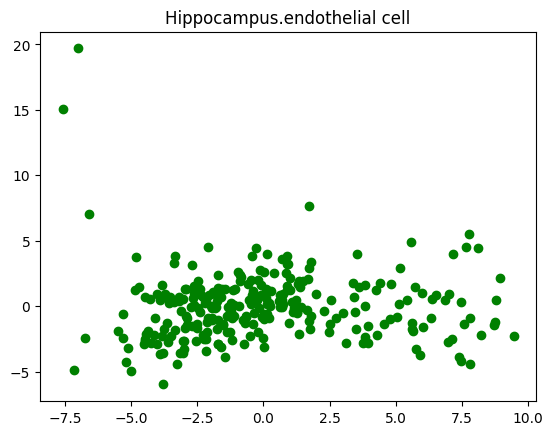

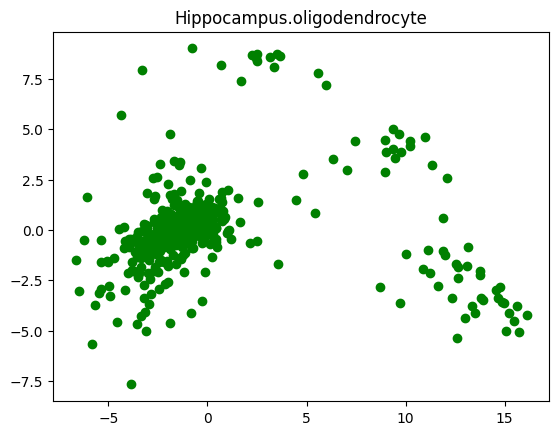

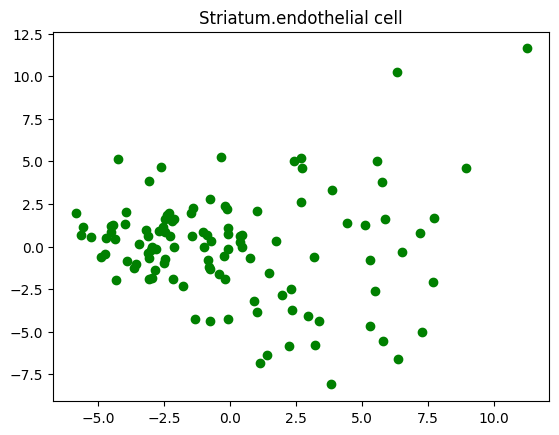

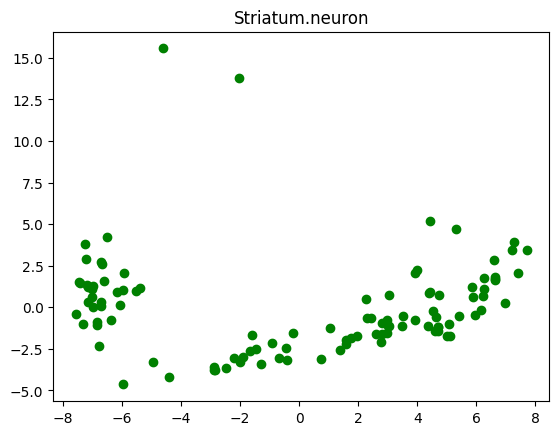

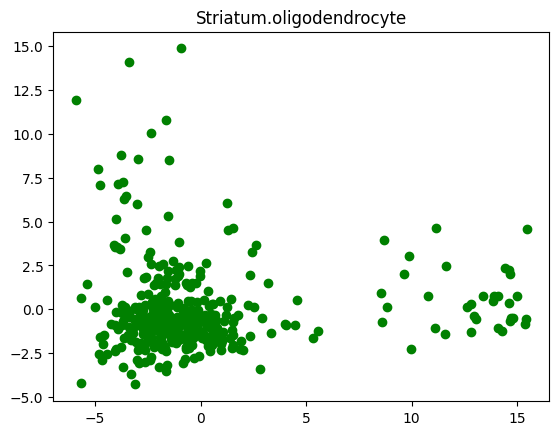

In [ ]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

for data, gender_labels, file_names, pred in zip(data_list, labels_gender_list, file_names_list, preds_list):

  pca = PCA(n_components=2)
  transformed_data = pca.fit_transform(data)

  # PCAs colored by gender.
  plt.scatter(transformed_data[pred==0, 0], transformed_data[pred==0, 1], color='green')
  plt.scatter(transformed_data[pred==1, 0], transformed_data[pred==1, 1], color='blue')
  plt.title(file_names)
  plt.show()

  # # PCAs colored by cell ontology.
  # plt.scatter(transformed_data[cell_labels==0, 0], transformed_data[cell_labels==0, 1], color='red')
  # plt.scatter(transformed_data[cell_labels==1, 0], transformed_data[cell_labels==1, 1], color='black')
  # plt.show()

Ground Truth PCA

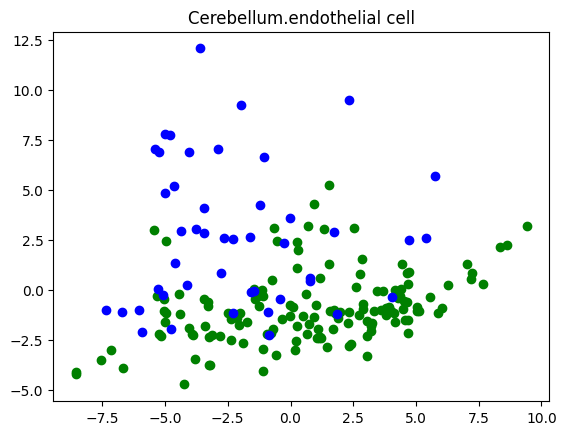

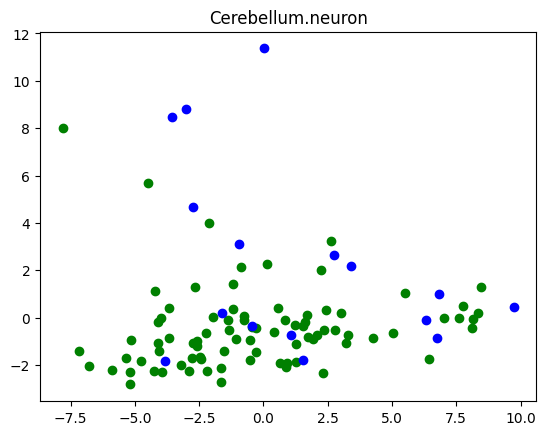

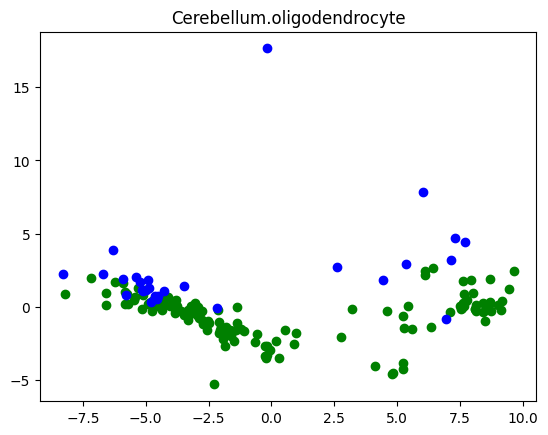

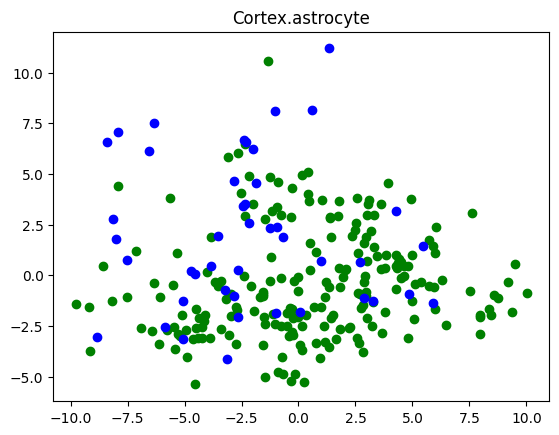

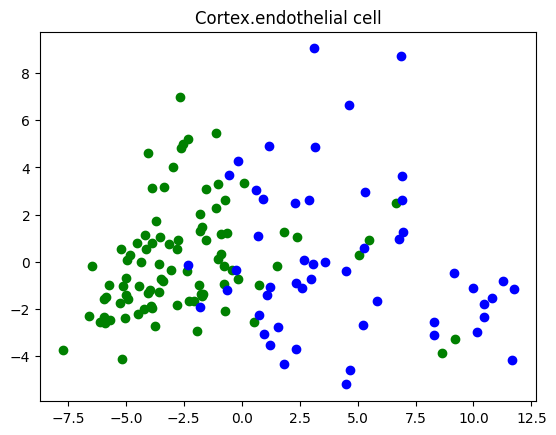

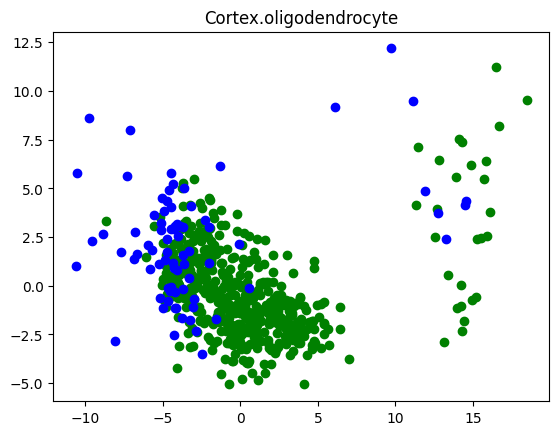

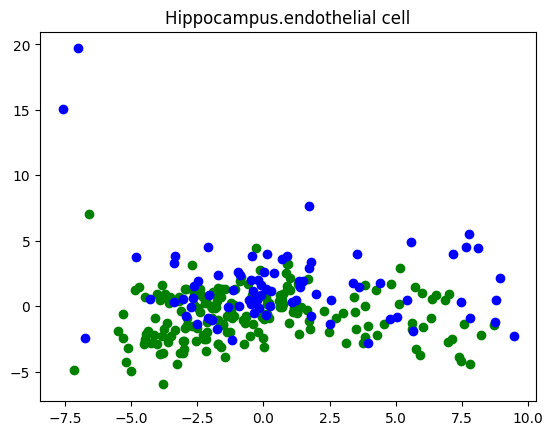

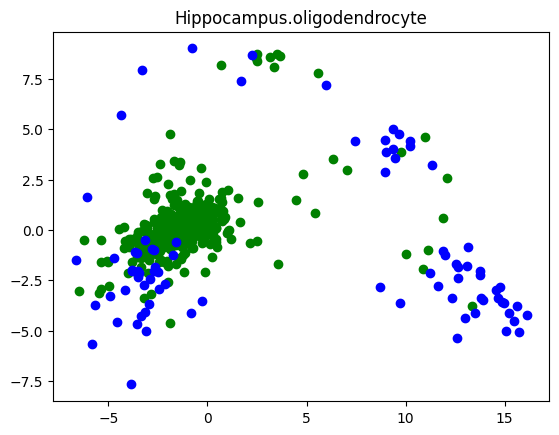

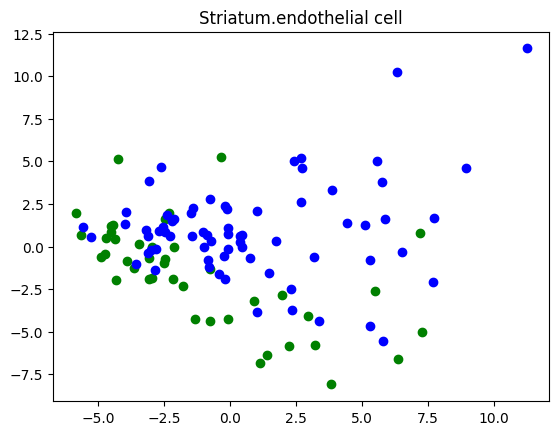

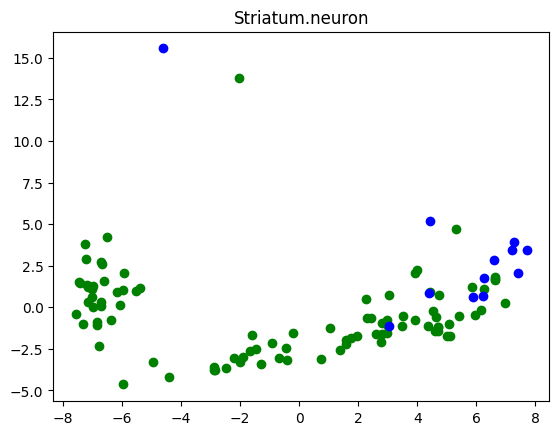

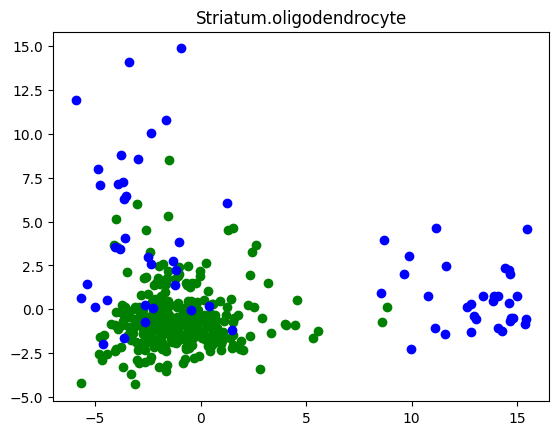

In [ ]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

for data, gender_labels, file_names in zip(data_list, labels_gender_list, file_names_list):

  pca = PCA(n_components=2)
  transformed_data = pca.fit_transform(data)

  # PCAs colored by gender.
  plt.scatter(transformed_data[gender_labels==0, 0], transformed_data[gender_labels==0, 1], color='green')
  plt.scatter(transformed_data[gender_labels==1, 0], transformed_data[gender_labels==1, 1], color='blue')
  plt.title(file_names)
  plt.show()

  # # PCAs colored by cell ontology.
  # plt.scatter(transformed_data[cell_labels==0, 0], transformed_data[cell_labels==0, 1], color='red')
  # plt.scatter(transformed_data[cell_labels==1, 0], transformed_data[cell_labels==1, 1], color='black')
  # plt.show()

# Real World Data: Both Gender and Cell Ontology Class

Loading and Pre-processing data

In [ ]:
data_file_list = glob.glob('/content/drive/MyDrive/ML project/comb_data_*.csv')
data_list = []
for file in data_file_list:
  data = pd.read_csv(file, index_col = 0)
  data = np.array(data)

  # normalize.
  normalized_data = data/np.sum(data, axis = 1)[:,np.newaxis]

  # scale.
  scaler = StandardScaler()
  single_cell_data_scaled = scaler.fit_transform(normalized_data)

  data_list.append(single_cell_data_scaled)


meta_file_list = glob.glob('/content/drive/MyDrive/ML project/comb_meta_*.csv')
labels_gender_list = []
labels_cell_list = []
labels_cell_names_list = []
for file in meta_file_list:
  file_name = '.'
  file_names_list.append(file_name.join(file.rstrip('.csv').split('_')[2:]))
  meta_data = pd.read_csv(file, index_col = 0)
  labels_gender = meta_data['mouse.sex'].apply(lambda x: 0 if x == 'M' else 1)
  labels_gender = np.array(labels_gender)
  labels_gender_list.append(labels_gender)

  classes = meta_data['cell_ontology_class']
  # labels_cell_names_list.append(classes)
  labels_cell = meta_data['cell_ontology_class'].apply(lambda x: 0 if x == classes[0] else 1)
  labels_cell = np.array(labels_cell)
  labels_cell_list.append(labels_cell)

Running the model

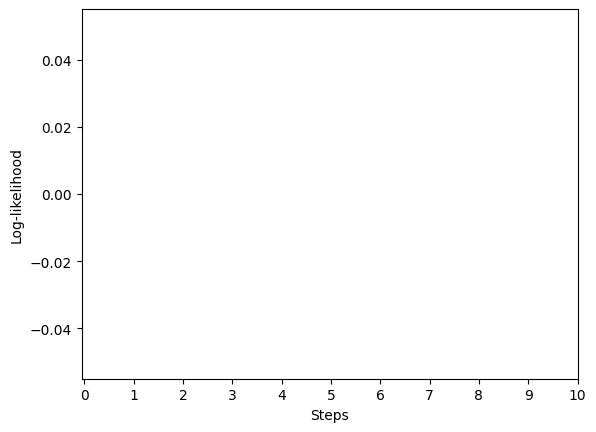

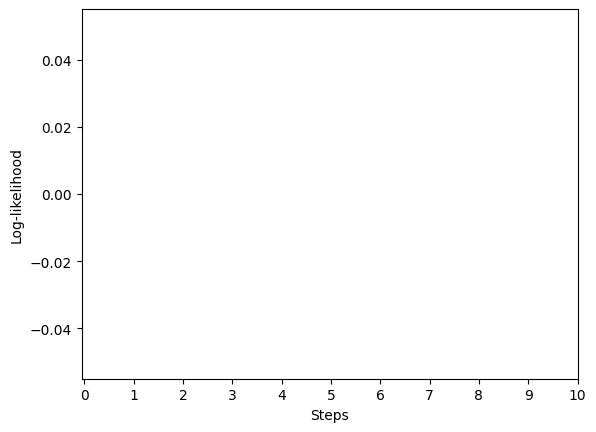

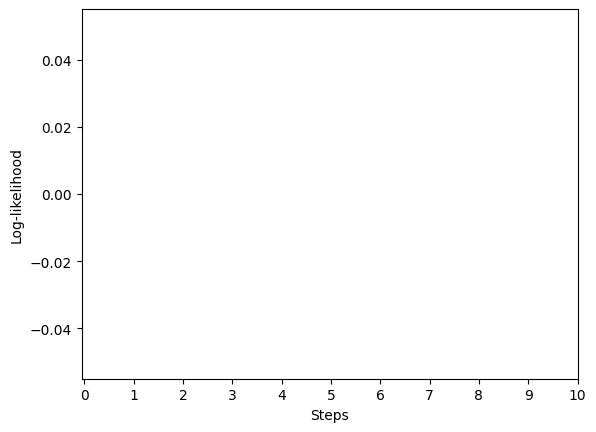

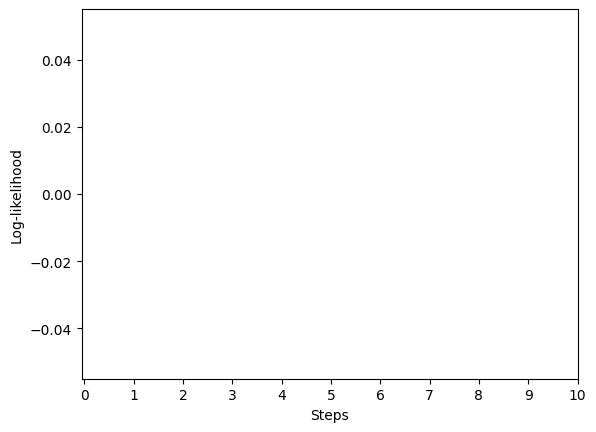

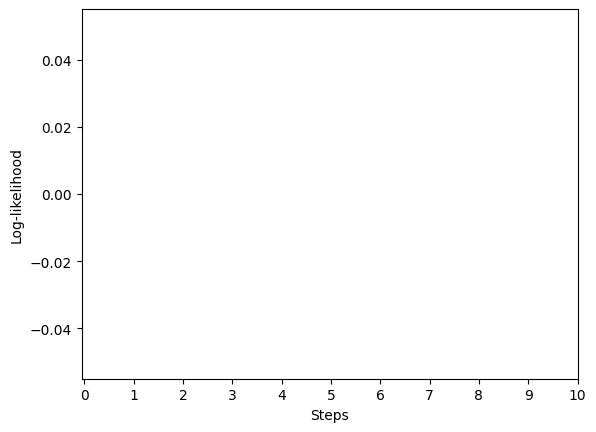

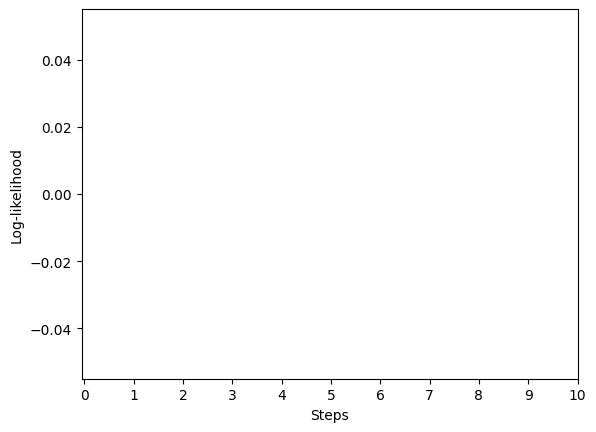

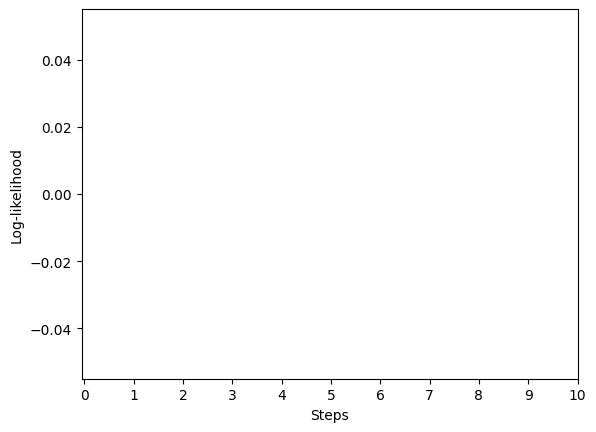

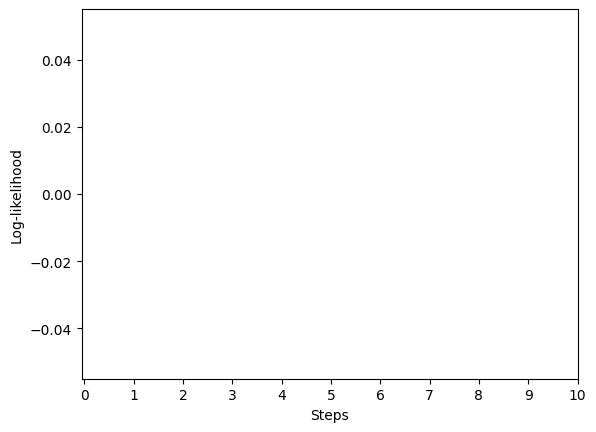

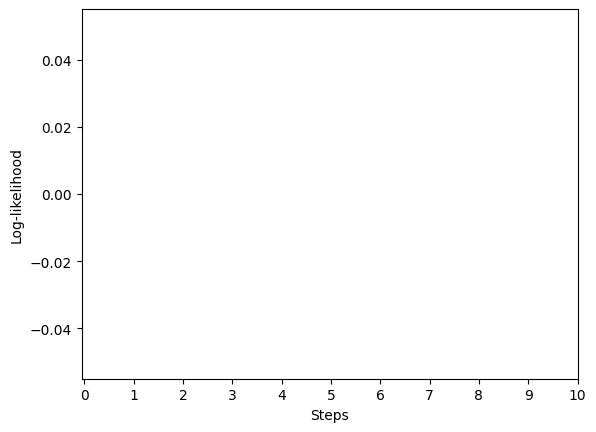

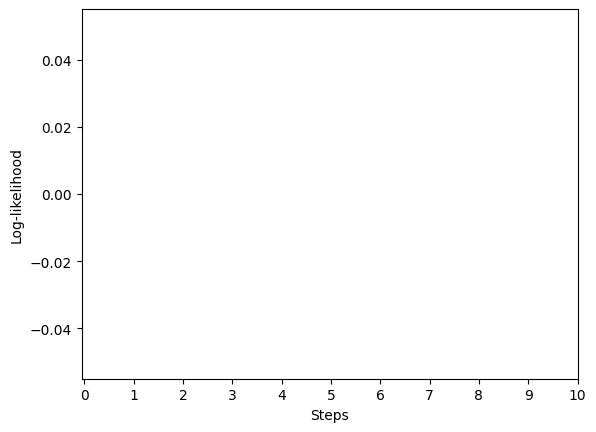

In [ ]:
num_clusters = 2

gender_scores_d = {}
cell_scores_d = {}
preds_list = []
for data, gender_labels, cell_labels, cell_names in zip(data_list, labels_gender_list, labels_cell_list, file_names_list):

  obj = poisson_clusters(data=single_cell_data_scaled, num_steps=10, tol = 1e-2)
  obj.fit(num_clusters=num_clusters)

  # predict.
  preds = np.argmax(obj.responsibilities, axis = 1)
  preds_list.append(preds)

  # evaluate.
  ## 1. gender.
  gender_scores_d[cell_names] = adjusted_rand_score(gender_labels, preds)
  ## 2. ontology.
  cell_scores_d[cell_names] = adjusted_rand_score(cell_labels, preds)

Adjusted Rand Scores

In [ ]:
gender_scores_d

{'Cerebellum.endothelial cell': 0.0,
 'Cerebellum.neuron': 0.0,
 'Cerebellum.oligodendrocyte': 0.0,
 'Cortex.astrocyte': 0.0,
 'Cortex.endothelial cell': 0.0,
 'Cortex.oligodendrocyte': 0.0,
 'Hippocampus.endothelial cell': 0.0,
 'Hippocampus.oligodendrocyte': 0.0,
 'Striatum.endothelial cell': 0.0,
 'Striatum.neuron': 0.0}

In [ ]:
cell_scores_d

{'Cerebellum.endothelial cell': 0.0,
 'Cerebellum.neuron': 0.0,
 'Cerebellum.oligodendrocyte': 0.0,
 'Cortex.astrocyte': 0.0,
 'Cortex.endothelial cell': 0.0,
 'Cortex.oligodendrocyte': 0.0,
 'Hippocampus.endothelial cell': 0.0,
 'Hippocampus.oligodendrocyte': 0.0,
 'Striatum.endothelial cell': 0.0,
 'Striatum.neuron': 0.0}

Predictions PCA

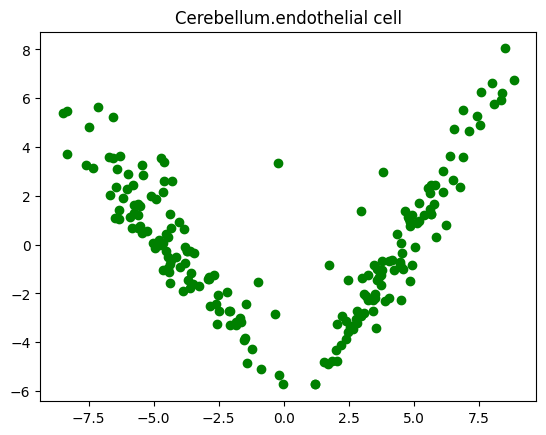

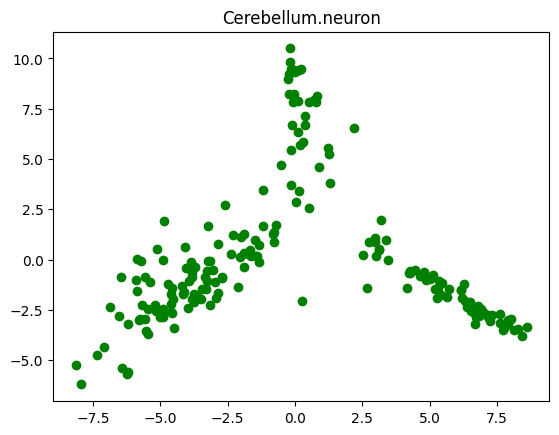

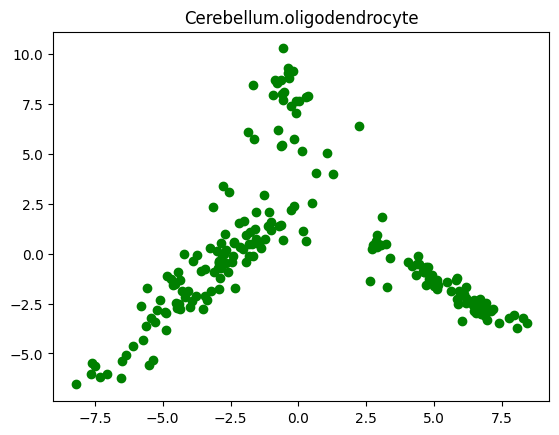

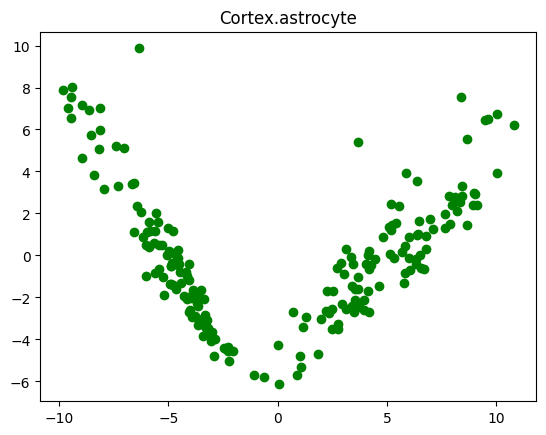

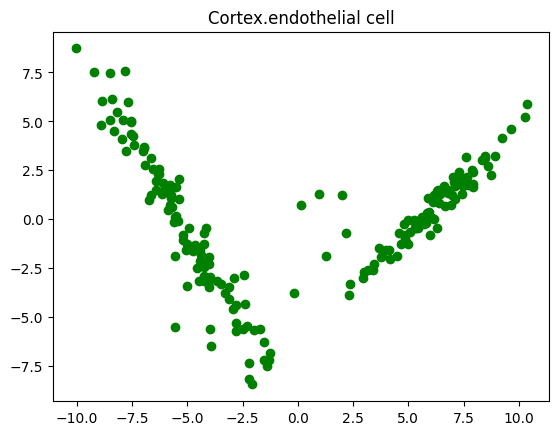

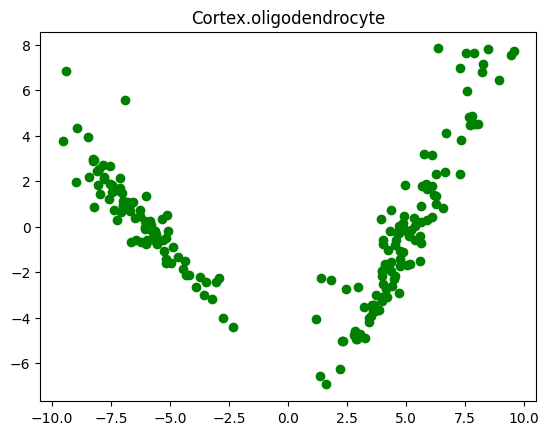

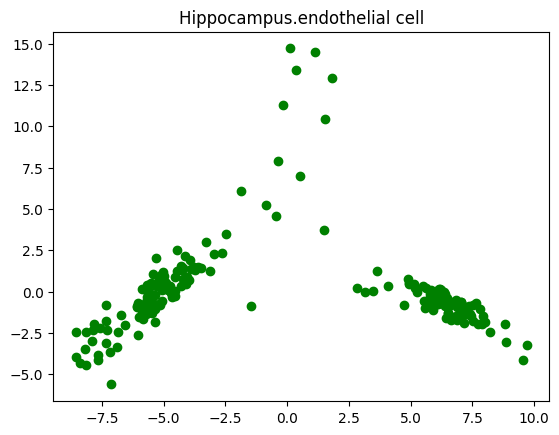

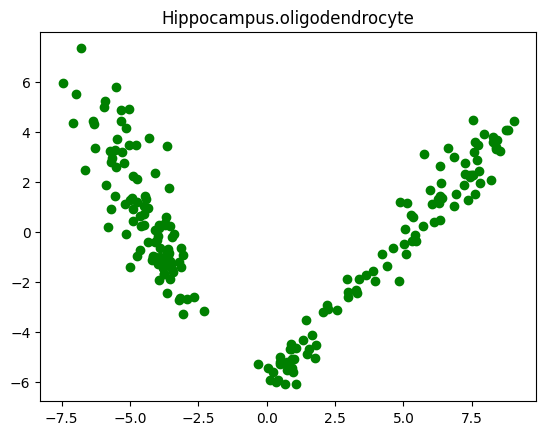

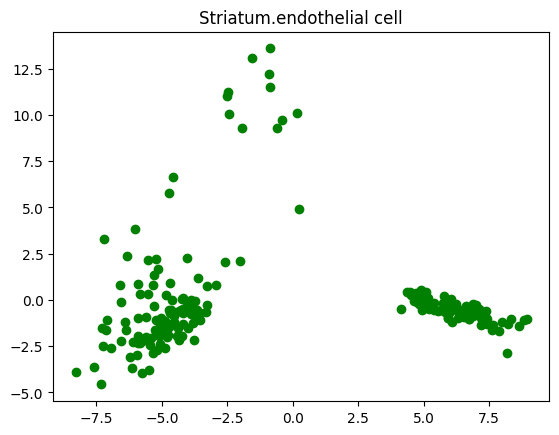

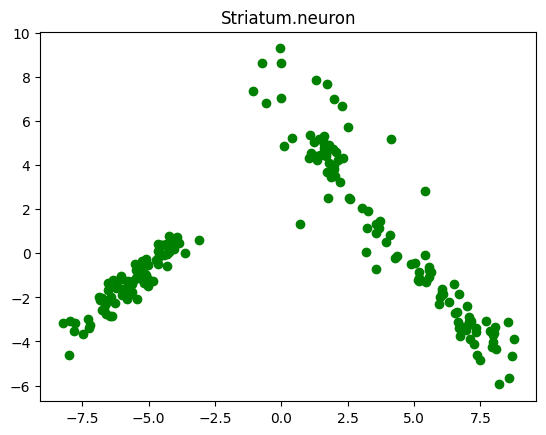

In [ ]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

for data, gender_labels, file_names, pred in zip(data_list, labels_gender_list, file_names_list, preds_list):

  pca = PCA(n_components=2)
  transformed_data = pca.fit_transform(data)

  # PCAs colored by gender.
  plt.scatter(transformed_data[pred==0, 0], transformed_data[pred==0, 1], color='green')
  plt.scatter(transformed_data[pred==1, 0], transformed_data[pred==1, 1], color='blue')
  plt.title(file_names)
  plt.show()

  # # PCAs colored by cell ontology.
  # plt.scatter(transformed_data[cell_labels==0, 0], transformed_data[cell_labels==0, 1], color='red')
  # plt.scatter(transformed_data[cell_labels==1, 0], transformed_data[cell_labels==1, 1], color='black')
  # plt.show()

Ground Truth PCA

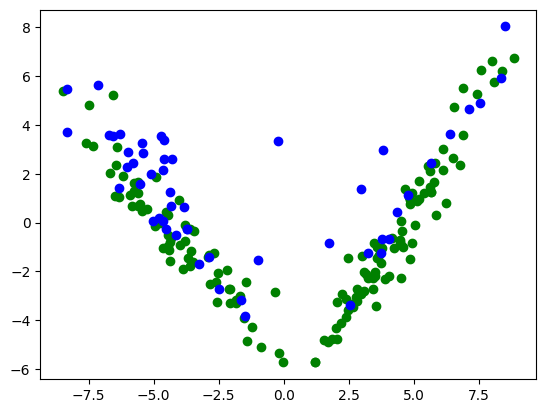

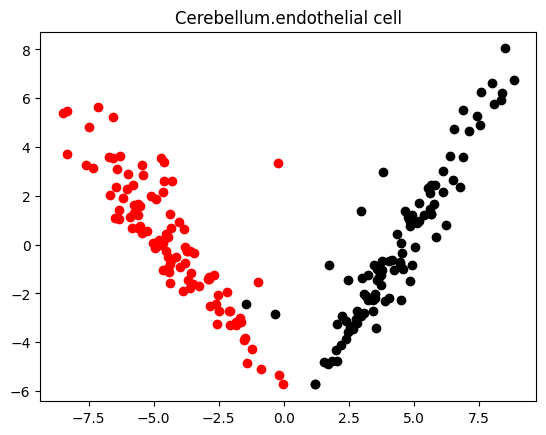

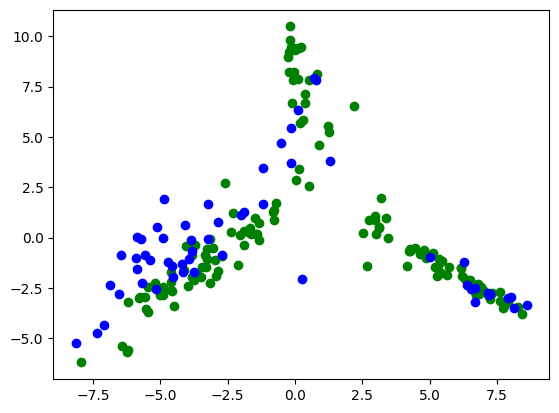

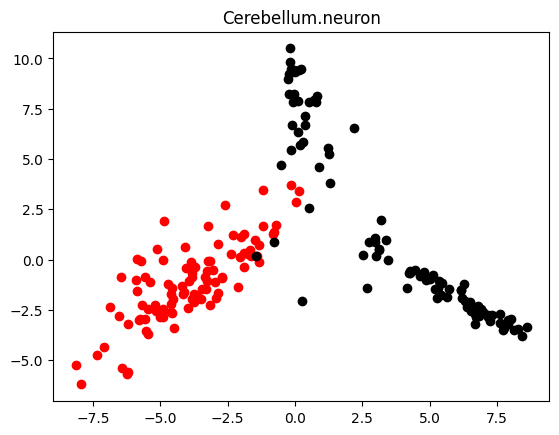

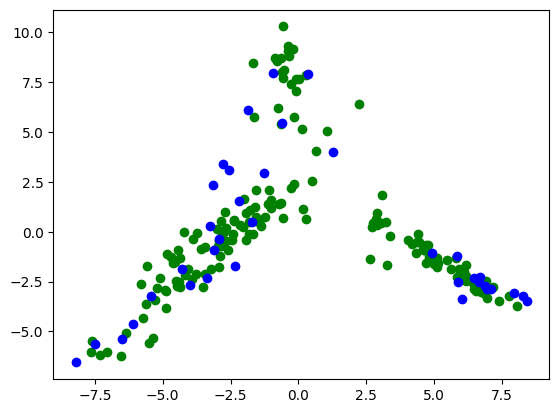

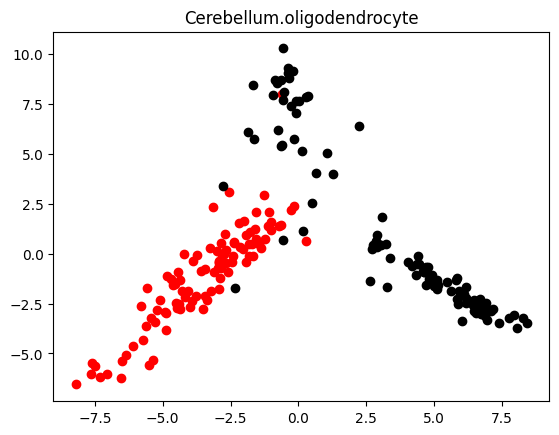

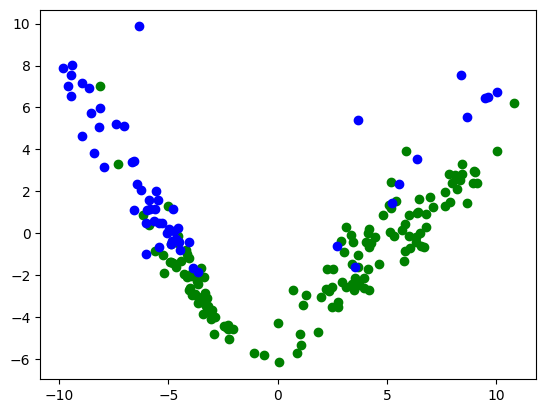

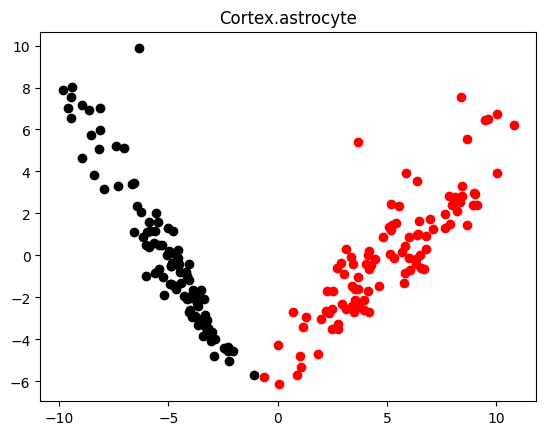

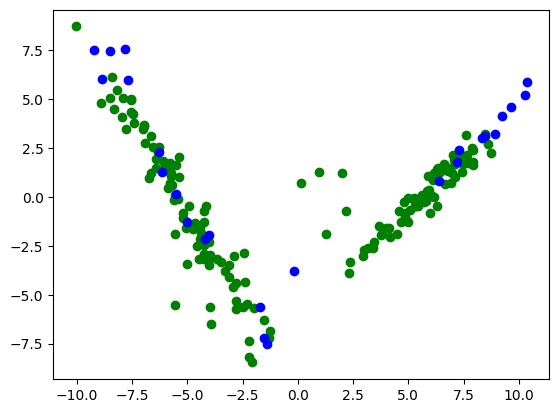

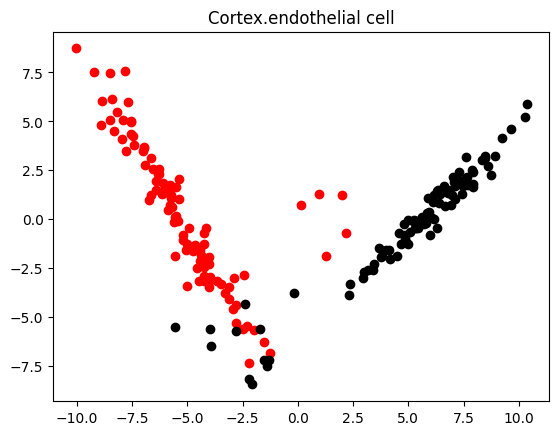

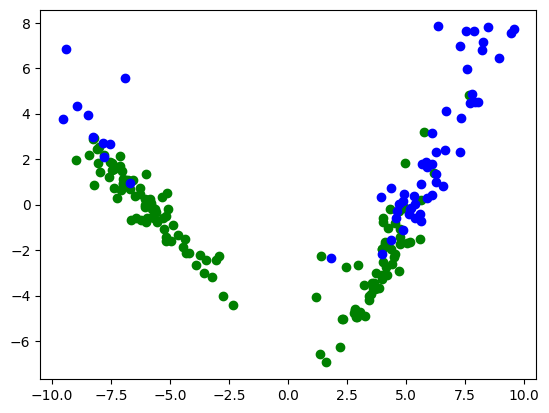

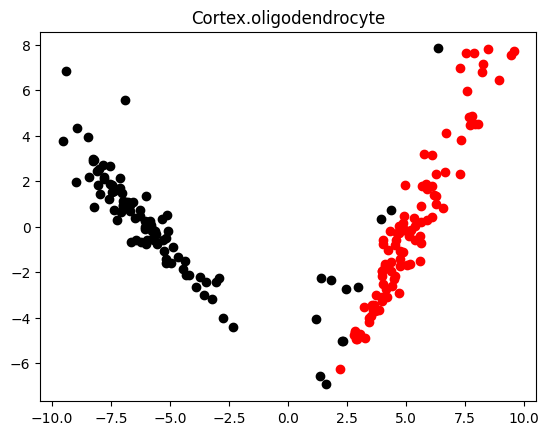

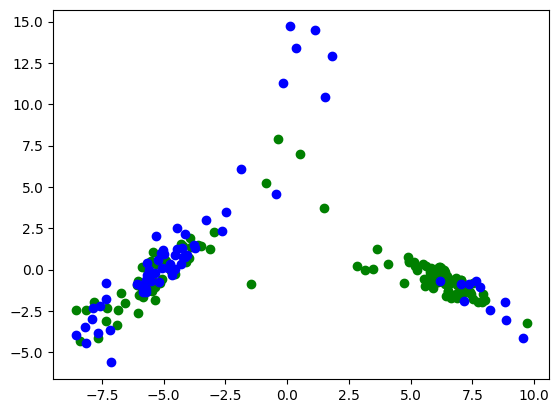

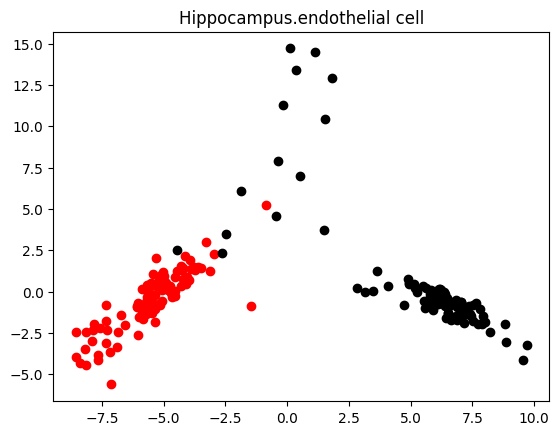

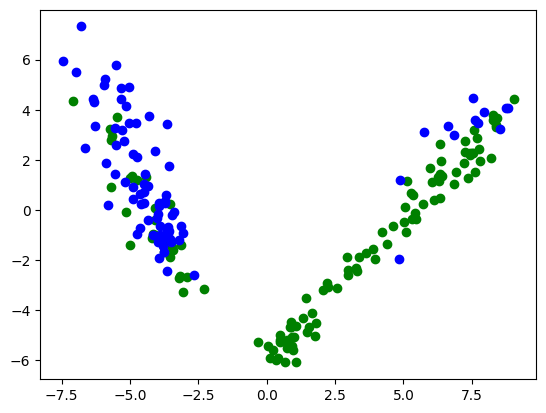

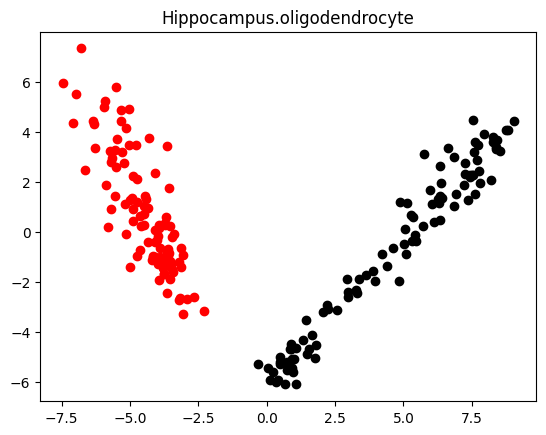

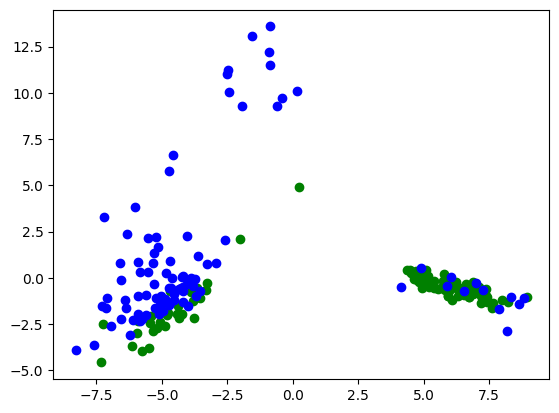

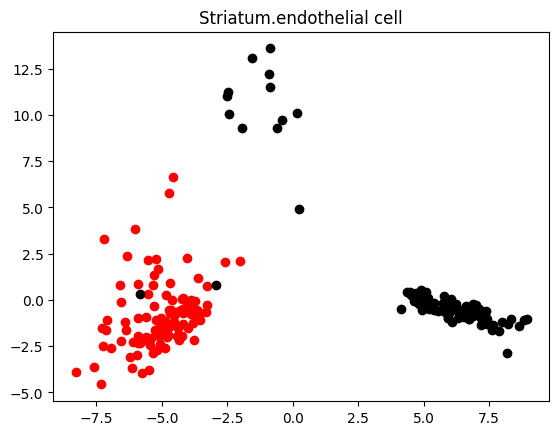

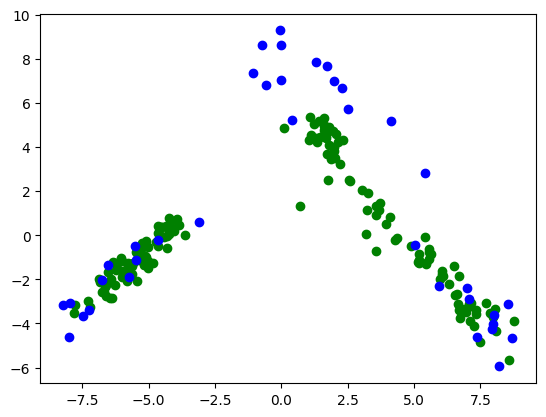

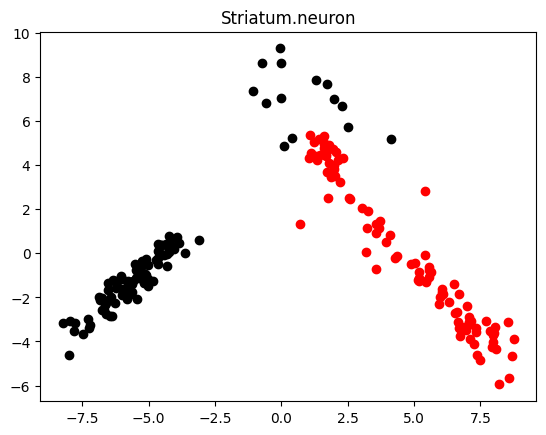

In [ ]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

for data, gender_labels, cell_labels, cell_names in zip(data_list, labels_gender_list, labels_cell_list, file_names_list):

  pca = PCA(n_components=2)
  transformed_data = pca.fit_transform(data)

  # PCAs colored by gender.
  plt.scatter(transformed_data[gender_labels==0, 0], transformed_data[gender_labels==0, 1], color='green')
  plt.scatter(transformed_data[gender_labels==1, 0], transformed_data[gender_labels==1, 1], color='blue')
  plt.show()

  # PCAs colored by cell ontology.
  plt.scatter(transformed_data[cell_labels==0, 0], transformed_data[cell_labels==0, 1], color='red')
  plt.scatter(transformed_data[cell_labels==1, 0], transformed_data[cell_labels==1, 1], color='black')
  plt.title(cell_names)
  plt.show()